# Classification of comments

The online store launches a new service. Now users can edit and supplement product descriptions like in wiki communities. That is, customers offer their edits and comment on others' changes. The store needs a tool that will search for toxic comments and send them for moderation.

Task:  
To train the model to categorize comments into positive and negative comments

Marked-up data on the toxicity of the edits are available for this purpose.  
F1-score should be at least 0.75.

In [1]:
import re
import nltk
import scipy
import warnings
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import lightgbm as lgb

from tqdm import notebook
from nltk import word_tokenize, pos_tag, TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from scipy.sparse import vstack
from sklearn.exceptions import ConvergenceWarning
from sklearn.feature_extraction.text import TfidfVectorizer 

from sklearn.utils import shuffle
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, PredefinedSplit

In [2]:
np.random.seed(57)

## Data

In [3]:
try:
    data = pd.read_csv('toxic_comments.csv')
except:
    data = pd.read_csv('/datasets/toxic_comments.csv')

In [4]:
data.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [5]:
data.drop(data.columns[0], axis=1, inplace=True)

In [6]:
data.isna().sum()

text     0
toxic    0
dtype: int64

In [7]:
data.duplicated().sum()

0

In [8]:
data.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


## Samples

I think 160,000 rows would take too long to process, so we should take a sample of 40000 rows.

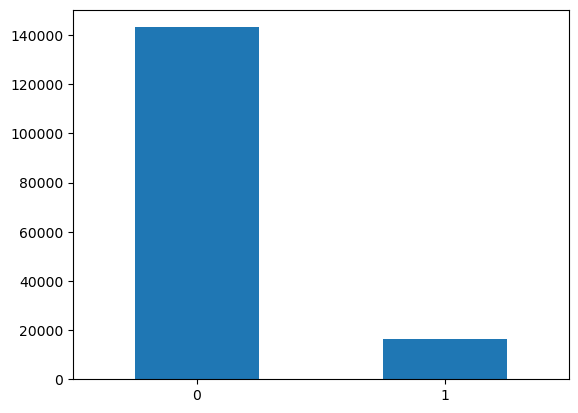

In [9]:
data['toxic'].value_counts().plot(kind='bar')
plt.xticks(rotation=0)
plt.show()

There is a serious class imbalance.  
I think the test sample should be allocated now, so that we can experiment with the training sample later.

In [10]:
data_test, data_valid, data_train = np.split(shuffle(data), [10000, 20000])
print(data_test.shape)
print(data_valid.shape)
print(data_train.shape)

(10000, 2)
(10000, 2)
(139292, 2)


Let's try two training samples: a normal sample and one considering class imbalance.

In [11]:
sample_train = data_train.sample(30000)
sample_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 154933 to 105885
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    30000 non-null  object
 1   toxic   30000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 703.1+ KB


In [12]:
data_neg = data_train[data_train['toxic'] == 0]
data_pos = data_train[data_train['toxic'] == 1]

sample_train_balanced = pd.concat([data_neg.sample(20000), data_pos.sample(10000)])
sample_train_balanced = shuffle(sample_train_balanced)

sample_train_balanced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 133857 to 71037
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    30000 non-null  object
 1   toxic   30000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 703.1+ KB


The test sample will need to be transformed based on the training sample, so we'll make a copy.

In [13]:
samples = {}
samples['train'] = {'raw': sample_train, 'balanced': sample_train_balanced}
samples['valid'] = {'raw': data_valid, 'balanced': data_valid.copy()}
samples['test'] = {'raw': data_test, 'balanced': data_test.copy()}

A dictionary to make code laconic.

In [14]:
samples['train']['balanced']['toxic'].value_counts()

0    20000
1    10000
Name: toxic, dtype: int64

## Text preprocessing

In [15]:
samples['train']['raw'].head()

,text,toxic
154933,"""\nYou're welcome. I do try my best. tlk. cntr...",0
5075,"""\nAt best, you could have deleted that portio...",0
82781,"""\n\nI agree that Raven has has a lot to do wi...",0
137923,Thank You\nKindly have a look here .,0
21756,"Will, whenever they 'saw him' and whenever th...",0


We need to keep only the letters and perform lemmatization.

### Symbols

In [16]:
for dataframe in samples['train'].values():
    dataframe['clear'] = dataframe['text'].apply(
        lambda text: ' '.join(re.sub(r'[^a-zA-Z ]', ' ', text).split()))

for dataframe in samples['valid'].values():
    dataframe['clear'] = dataframe['text'].apply(
        lambda text: ' '.join(re.sub(r'[^a-zA-Z ]', ' ', text).split()))       
    
for dataframe in samples['test'].values():
    dataframe['clear'] = dataframe['text'].apply(
        lambda text: ' '.join(re.sub(r'[^a-zA-Z ]', ' ', text).split()))    

In [17]:
samples['train']['raw'].head()

,text,toxic,clear
154933,"""\nYou're welcome. I do try my best. tlk. cntr...",0,You re welcome I do try my best tlk cntrb
5075,"""\nAt best, you could have deleted that portio...",0,At best you could have deleted that portion of...
82781,"""\n\nI agree that Raven has has a lot to do wi...",0,I agree that Raven has has a lot to do with th...
137923,Thank You\nKindly have a look here .,0,Thank You Kindly have a look here
21756,"Will, whenever they 'saw him' and whenever th...",0,Will whenever they saw him and whenever they w...


We got rid of the obstructing characters.

### Lemmatization

In [18]:
lemm = WordNetLemmatizer()
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /home/leonid/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/leonid/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /home/leonid/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/leonid/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [19]:
for dataframe in samples['train'].values():
    dataframe['lemm_text'] = dataframe['clear'].apply(
    lambda text: ' '.join([lemm.lemmatize(word, pos=pos[0].lower()) 
                           if pos[0].lower() in wordnet._pos_names.values() 
                           else lemm.lemmatize(word) 
                           for word, pos in pos_tag(word_tokenize(text.lower()))]))

for dataframe in samples['valid'].values():
    dataframe['lemm_text'] = dataframe['clear'].apply(
    lambda text: ' '.join([lemm.lemmatize(word, pos=pos[0].lower()) 
                           if pos[0].lower() in wordnet._pos_names.values() 
                           else lemm.lemmatize(word) 
                           for word, pos in pos_tag(word_tokenize(text.lower()))]))    
    
for dataframe in samples['test'].values():
    dataframe['lemm_text'] = dataframe['clear'].apply(
    lambda text: ' '.join([lemm.lemmatize(word, pos=pos[0].lower()) 
                           if pos[0].lower() in wordnet._pos_names.values() 
                           else lemm.lemmatize(word) 
                           for word, pos in pos_tag(word_tokenize(text.lower()))]))

In [20]:
samples['train']['raw'].head()

,text,toxic,clear,lemm_text
154933,"""\nYou're welcome. I do try my best. tlk. cntr...",0,You re welcome I do try my best tlk cntrb,you re welcome i do try my best tlk cntrb
5075,"""\nAt best, you could have deleted that portio...",0,At best you could have deleted that portion of...,at best you could have delete that portion of ...
82781,"""\n\nI agree that Raven has has a lot to do wi...",0,I agree that Raven has has a lot to do with th...,i agree that raven have have a lot to do with ...
137923,Thank You\nKindly have a look here .,0,Thank You Kindly have a look here,thank you kindly have a look here
21756,"Will, whenever they 'saw him' and whenever th...",0,Will whenever they saw him and whenever they w...,will whenever they saw him and whenever they b...


In [21]:
corpus = {}
target = {}

corpus['raw'] = {'train': samples['train']['raw']['lemm_text'], 
                 'valid': samples['valid']['raw']['lemm_text'], 
                 'test': samples['test']['raw']['lemm_text']}
corpus['balanced'] = {'train': samples['train']['balanced']['lemm_text'], 
                      'valid': samples['valid']['balanced']['lemm_text'], 
                      'test': samples['test']['balanced']['lemm_text']}

target['raw'] = {'train': samples['train']['raw']['toxic'], 
                 'valid': samples['valid']['raw']['toxic'], 
                 'test': samples['test']['raw']['toxic']}
target['balanced'] = {'train': samples['train']['balanced']['toxic'], 
                      'valid': samples['valid']['balanced']['toxic'], 
                      'test': samples['test']['balanced']['toxic']}

In [22]:
corpus['balanced']['train'].head()

133857    oh i would like to ad that the reason for my b...
124188    hear the voice in my head i swear to god it so...
23378          you need to re read the purpose of wikipedia
106745    please refrain from add nonsense to wikipedia ...
64563     picture youy mother with her wrinkle up as in ...
Name: lemm_text, dtype: object

In [23]:
target['raw']['valid'].head()

80902     0
76700     1
133696    0
84672     0
1064      0
Name: toxic, dtype: int64

### Word frequency

Let's remove frequent uninformative words.

In [24]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/leonid/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
tf_idf = {}

for approach in 'raw', 'balanced':
    count_tf_idf = TfidfVectorizer(stop_words=stop_words) 
    count_tf_idf.fit(pd.concat([corpus[approach]['train'], corpus[approach]['valid']]))
    
    tf_idf[approach] = {'train': count_tf_idf.transform(corpus[approach]['train']), 
                        'valid': count_tf_idf.transform(corpus[approach]['valid']), 
                        'test': count_tf_idf.transform(corpus[approach]['test'])}

In [26]:
print(tf_idf['raw']['train'].shape)
print(tf_idf['raw']['valid'].shape)
print(tf_idf['raw']['test'].shape)
print()
print(tf_idf['balanced']['train'].shape)
print(tf_idf['balanced']['valid'].shape)
print(tf_idf['balanced']['test'].shape)

(30000, 67135)
(10000, 67135)
(10000, 67135)

(30000, 65603)
(10000, 65603)
(10000, 65603)


## Training

Let's consider logistic regression, decision tree, random forest and LightGBM.

### Logistic regression

In [27]:
%%time
warnings.filterwarnings('ignore', category=ConvergenceWarning)
params_grid = {'l1_ratio': [0, 0.3, 0.7, 1], 
               'class_weight': [None, 'balanced']}

model = GridSearchCV(estimator=LogisticRegression(solver='saga', 
                                                  penalty='elasticnet', 
                                                  max_iter=1000), 
                     param_grid=params_grid, 
                     scoring='f1')

model.fit(vstack((tf_idf['raw']['train'], tf_idf['raw']['valid'])), 
          pd.concat([target['raw']['train'], target['raw']['valid']]))
print(model.best_params_)
print(model.best_score_)

{'class_weight': 'balanced', 'l1_ratio': 0.7}
0.7201254626986577
CPU times: user 1h 46min 15s, sys: 1.12 s, total: 1h 46min 16s
Wall time: 1h 46min 19s


{'class_weight': 'balanced', 'l1_ratio': 0.7}  
0.7201254626986577  
CPU times: user 1h 35min 50s, sys: 675 ms, total: 1h 35min 51s  
Wall time: 1h 36min

In [28]:
%%time
best_f1 = 0
best_model = None
for l1_ratio in [0, 0.3, 0.7, 1]:
    for class_weight in [None, 'balanced']:
        model = LogisticRegression(solver='saga', 
                                   l1_ratio=l1_ratio, 
                                   class_weight=class_weight, 
                                   penalty='elasticnet', 
                                   max_iter=1000)
        model.fit(tf_idf['balanced']['train'], target['balanced']['train'])
        predictions_valid = model.predict(tf_idf['balanced']['valid'])
        current_f1 = f1_score(target['balanced']['valid'], predictions_valid)
        if current_f1 > best_f1:
            best_model = model
            best_f1 = current_f1
print(model.get_params())
print('F1-score:', best_f1)

{'C': 1.0, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 1, 'max_iter': 1000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
F1-score: 0.7534246575342466
CPU times: user 45.7 s, sys: 2 ms, total: 45.8 s
Wall time: 45.7 s


### Decision Tree

In [29]:
%%time
params_grid = {'max_depth': range(1, 50, 7), 
               'class_weight': [None, 'balanced']}

model = GridSearchCV(estimator=DecisionTreeClassifier(random_state=57), 
                     param_grid=params_grid, 
                     scoring='f1')

model.fit(vstack((tf_idf['raw']['train'], tf_idf['raw']['valid'])), 
          pd.concat([target['raw']['train'], target['raw']['valid']]))
print(model.best_params_)
print(model.best_score_)

{'class_weight': None, 'max_depth': 43}
0.6860495486690436
CPU times: user 5min 53s, sys: 1.32 s, total: 5min 54s
Wall time: 5min 55s


In [30]:
%%time
best_f1 = 0
best_model = None
for max_depth in range(1, 50, 7):
    for class_weight in [None, 'balanced']:
        model = DecisionTreeClassifier(max_depth=max_depth, 
                                       class_weight=class_weight, 
                                       random_state=57)
        model.fit(tf_idf['balanced']['train'], target['balanced']['train'])
        predictions_valid = model.predict(tf_idf['balanced']['valid'])
        current_f1 = f1_score(target['balanced']['valid'], predictions_valid)
        if current_f1 > best_f1:
            best_model = model
            best_f1 = current_f1
print(model.get_params())
print('F1-score:', best_f1)

{'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 43, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 57, 'splitter': 'best'}
F1-score: 0.6796326310102648
CPU times: user 1min 7s, sys: 29 ms, total: 1min 7s
Wall time: 1min 7s


### Random Forest

In [31]:
%%time
params_grid = {'max_depth': range(1, 22, 5), 
               'n_estimators': range(1, 302, 100)}

model = GridSearchCV(estimator=RandomForestClassifier(random_state=57), 
                     param_grid=params_grid, 
                     scoring='f1')

model.fit(vstack((tf_idf['raw']['train'], tf_idf['raw']['valid'])), 
          pd.concat([target['raw']['train'], target['raw']['valid']]))
print(model.best_params_)
print(model.best_score_)

{'max_depth': 21, 'n_estimators': 1}
0.16948032682016934
CPU times: user 14min 42s, sys: 1.17 s, total: 14min 43s
Wall time: 14min 43s


In [32]:
%%time
best_f1 = 0
best_model = None
for max_depth in range(1, 22, 5):
    for n_estimators in range(1, 302, 100):
        model = RandomForestClassifier(max_depth=max_depth, 
                                       n_estimators=n_estimators, 
                                       random_state=57)
        model.fit(tf_idf['balanced']['train'], target['balanced']['train'])
        predictions_valid = model.predict(tf_idf['balanced']['valid'])
        current_f1 = f1_score(target['balanced']['valid'], predictions_valid)
        if current_f1 > best_f1:
            best_model = model
            best_f1 = current_f1
print(model.get_params())
print('F1-score:', best_f1)

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 21, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 301, 'n_jobs': None, 'oob_score': False, 'random_state': 57, 'verbose': 0, 'warm_start': False}
F1-score: 0.16498054474708168
CPU times: user 3min 1s, sys: 64 ms, total: 3min 1s
Wall time: 3min 1s


Not really sure why it's worse than the decision tree. It's deep enough.

### LightGBM

In [33]:
%%time
params_grid = {'learning_rate': [0.05, 0.1, 0.2], 
               'n_estimators': [50, 100, 150, 200], 
               'colsample_bytree': [0.5, 0.7, 1.0]}

model = GridSearchCV(estimator=lgb.LGBMClassifier(objective='binary', 
                                                  random_state=57), 
                     param_grid=params_grid, 
                     scoring='f1')

model.fit(vstack((tf_idf['raw']['train'], tf_idf['raw']['valid'])), 
          pd.concat([target['raw']['train'], target['raw']['valid']]))
print(model.best_params_)
print(model.best_score_)

{'colsample_bytree': 0.5, 'learning_rate': 0.2, 'n_estimators': 150}
0.7332954922894052
CPU times: user 6h 7min 33s, sys: 18min 12s, total: 6h 25min 46s
Wall time: 51min 46s


In [34]:
%%time
best_f1 = 0
best_model = None
for learning_rate in [0.05, 0.1, 0.2]:
    for n_estimators in [50, 100, 150, 200]:
        for colsample_bytree in [0.5, 0.7, 1.0]:
            model = lgb.LGBMClassifier(objective='binary', 
                                       learning_rate=learning_rate, 
                                       n_estimators=n_estimators, 
                                       colsample_bytree=colsample_bytree, 
                                       random_state=57)
            model.fit(tf_idf['balanced']['train'], target['balanced']['train'])
            predictions_valid = model.predict(tf_idf['balanced']['valid'])
            current_f1 = f1_score(target['balanced']['valid'], predictions_valid)
            if current_f1 > best_f1:
                best_model = model
                best_f1 = current_f1
print(model.get_params())
print('F1-score:', best_f1)

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.2, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 200, 'n_jobs': -1, 'num_leaves': 31, 'objective': 'binary', 'random_state': 57, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}
F1-score: 0.7537840565085772
CPU times: user 1h 6min 5s, sys: 3min 13s, total: 1h 9min 19s
Wall time: 9min 13s


### Results

||Original sample|Balanced sample|
|-|-|-|
|Logistic regression|0.720|0.753|
|Decision tree|0.686|0.680|
|Random forest|0.170|0.365|
|LightGBM|0.733|**0.754**|

Thus, testing LightGBM.

## Sanity check

In [35]:
cross_val_score(DummyClassifier(strategy='stratified'), 
                tf_idf['balanced']['train'], 
                target['balanced']['train'], scoring='f1').mean()

0.33482774522241765

On the other hand, if it only hits zeros and logistic regression doesn't, the latter might make sense.

In [36]:
def plot_confusion_matrix(model, features_valid, target_valid):
    predicted_valid = model.predict(features_valid)

    print('Confusion matrix:')
    print(confusion_matrix(target_valid, predicted_valid))
    
    fig, ax = plt.subplots()
    fig = sb.heatmap(confusion_matrix(target_valid, predicted_valid, normalize='true'), 
                     annot=True)
    plt.yticks(rotation=0)
    ax.set_ylabel('Answers', rotation=0);
    ax.set_xlabel('Predictions');
    ax.yaxis.labelpad = 20
    plt.show()

In [37]:
feautres_train, features_valid, target_train, target_valid = train_test_split(
    tf_idf['raw']['train'], target['raw']['train'])

Confusion matrix:
[[6101  664]
 [ 678   57]]


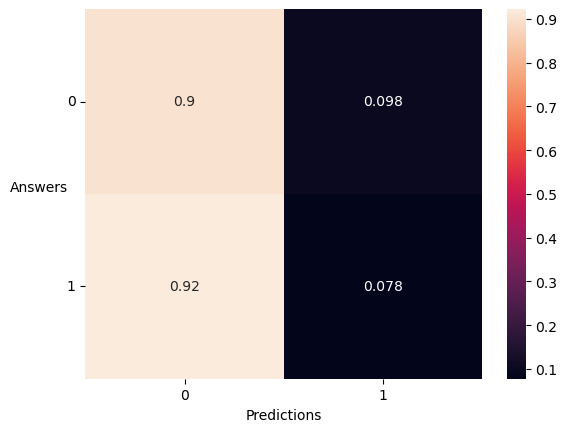

In [38]:
model = DummyClassifier(strategy='stratified')
model.fit(features_valid, target_valid)
plot_confusion_matrix(model, features_valid, target_valid)

I'll compare results to this one.

## Testing

0.782033096926714
Confusion matrix:
[[8712  263]
 [ 198  827]]


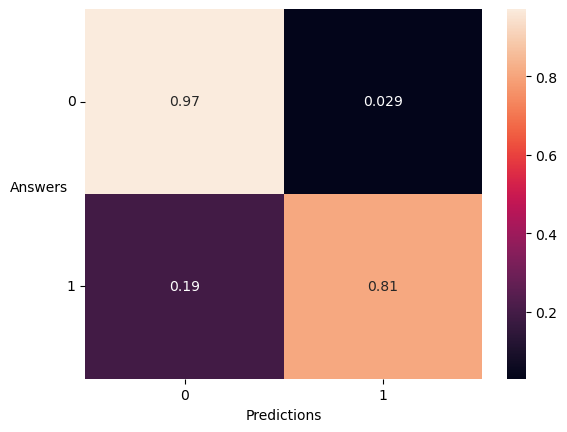

In [39]:
model = lgb.LGBMClassifier(objective='binary', 
                           learning_rate=0.2, 
                           n_estimators=200, 
                           colsample_bytree=1.0, 
                           random_state=57)

model.fit(vstack((tf_idf['balanced']['train'], tf_idf['balanced']['valid'])), 
          pd.concat([target['balanced']['train'], target['balanced']['valid']]))

predictions = model.predict(tf_idf['balanced']['test'])
print(f1_score(target['balanced']['test'], predictions))
plot_confusion_matrix(model, tf_idf['balanced']['test'], target['balanced']['test'])

Out of interest, let's also try a regression.

0.7357640311347808
Confusion matrix:
[[8457  518]
 [ 127  898]]


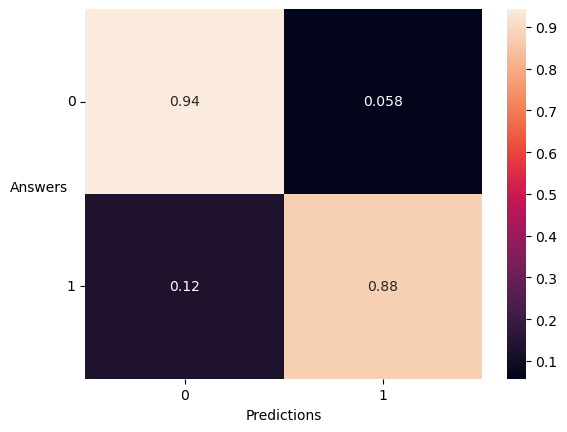

In [40]:
model = LogisticRegression(solver='saga', 
                           l1_ratio=1.0, 
                           class_weight='balanced', 
                           penalty='elasticnet', 
                           max_iter=1000)

model.fit(vstack((tf_idf['balanced']['train'], tf_idf['balanced']['valid'])), 
          pd.concat([target['balanced']['train'], target['balanced']['valid']]))

predictions = model.predict(tf_idf['balanced']['test'])
print(f1_score(target['balanced']['test'], predictions))
plot_confusion_matrix(model, tf_idf['balanced']['test'], target['balanced']['test'])

F1-score is worse, although recall is higher than in the boosting case.

## Conclusions

1. The data represent 160,000 English-language comments.
2. There is an imbalance of classes in the data (10% labeled as toxic).
3. A sample of 50000 comments was taken for training and testing.
4. Before training, lemmatization was performed with WordNetLemmatizer() function.
5. Logistic regression, decision tree, random forest and LightGBM were taken for training.
6. The LightGBM model trained on upsampled sample showed the best F1-score.
7. In testing, this model showed F1-score equal to 0.782.